# Detect not useful ids

## Packages and Data

In [19]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from utils.data_loader import DataLoader
from utils.calculate_indices import CalculateIndices
from utils.preprocessing import Preprocessing
from utils.visualization_utils.visualization_time_series import plot_timeseries_oneid
from utils.correlation_analysis import CorrelationAnalysis

from pipelines.processing.processing_steps.detect_disturbed_trees import DetectDisturbedTrees

from utils.constants import spectral_bands, indices

bands_and_indices = spectral_bands + indices

In [27]:
dataloader = DataLoader()
df_base = dataloader.load_transform("../../data/preprocessed/trainset.csv")
df = dataloader.date_feature_extraction(df_base)
df = dataloader.feature_extraction(df)

df = Preprocessing.interpolate_b4(df, method="linear")

calculateindices = CalculateIndices()
df = calculateindices.add_all_indices(df)

In [28]:
df

,time,id,disturbance_year,doy,b2,b3,b4,b5,b6,b7,...,ndvi,gndvi,wdvi,tndvi,savi,ipvi,mcari,reip,masvi2,dvi
0,2017-01-13,4,0.0,13.0,176.0,229.0,205.0,405.0,1192.0,1308.0,...,0.730440,0.702017,1213.5,1.109252,1.095301,0.865220,325.580488,717.865311,-0.999240,1111.0
1,2017-01-27,4,0.0,27.0,382.0,429.0,205.0,405.0,1192.0,1308.0,...,0.730440,0.506045,1213.5,1.109252,1.095301,0.865220,404.604878,717.865311,-0.999240,1111.0
2,2017-02-19,4,0.0,50.0,240.0,382.0,259.0,544.0,1387.0,1609.0,...,0.751440,0.616273,1695.5,1.118678,1.126889,0.875720,530.557529,718.505338,-0.999452,1566.0
3,2017-03-27,4,0.0,86.0,244.0,375.0,287.0,579.0,1536.0,1776.0,...,0.734873,0.651325,1734.5,1.111248,1.102055,0.867436,506.776307,718.913271,-0.999468,1591.0
4,2017-04-27,4,0.0,117.0,215.0,327.0,274.0,548.0,1499.0,1803.0,...,0.731373,0.692958,1629.0,1.109672,1.096790,0.865686,459.600000,720.630915,-0.999434,1492.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2752780,2022-08-06,28210,0.0,218.0,469.0,672.0,764.0,1116.0,1829.0,2302.0,...,0.539343,0.548083,2171.0,1.019482,0.808892,0.769671,384.464921,723.394109,-0.999608,1789.0
2752781,2022-08-09,28210,0.0,221.0,515.0,778.0,930.0,1142.0,2016.0,2442.0,...,0.457251,0.516770,2032.0,0.978392,0.685777,0.728626,170.931613,724.897025,-0.999600,1567.0
2752782,2022-08-12,28210,0.0,224.0,483.0,829.0,1013.0,1182.0,1986.0,2210.0,...,0.455669,0.454426,2202.5,0.977583,0.683412,0.727834,114.816190,721.368159,-0.999631,1696.0
2752783,2022-08-23,28210,0.0,235.0,493.0,737.0,844.0,1009.0,2030.0,2352.0,...,0.490184,0.522823,2045.0,0.995080,0.735165,0.745092,132.222038,723.075416,-0.999595,1623.0


## Analysis size of ids

### Size of monthly data

In [ ]:
bands_and_indices = spectral_bands + indices
df_monthly = df.groupby(["id", "year", "month_num"])[bands_and_indices].mean().reset_index()

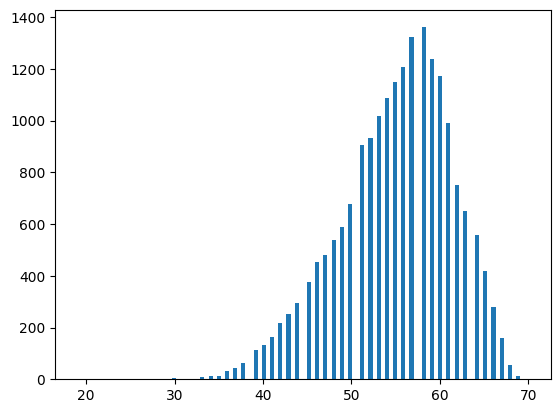

In [ ]:
df_size = df_monthly.groupby("id").size()

plt.hist(df_size, bins=110)
plt.show()

In [42]:
df_size

id
4        53
6        53
7        42
9        49
11       52
         ..
28206    53
28207    60
28208    59
28209    55
28210    49
Length: 19748, dtype: int64

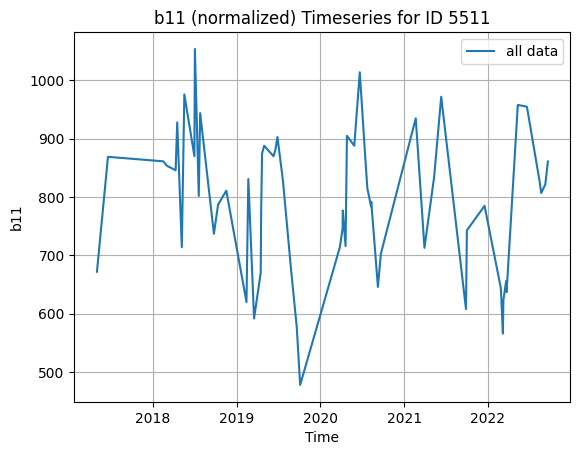

In [66]:
plot_timeseries_oneid(
    df, 5511, "b11", yearly_mean=False
)

### Gap analysis

In [ ]:
# assume df has ['id', 'time', 'date_diff', ...]
# ensure datetime type
df['time'] = pd.to_datetime(df['time'])

# 1. sort
df = df.sort_values(['id', 'time'])

# 2. resample / aggregate to 2-week intervals per ID
# (mean of spectral bands, for example)
agg_cols = [c for c in df.columns if c.startswith('b')]
df_2w = (
    df.set_index('time')
      .groupby('id')
      .resample('2W')[agg_cols]   # 2-week frequency
      .mean()
      .reset_index()
)

# 3. compute time gaps (in days)
df_2w['date_diff'] = (
    df_2w.groupby('id')['time']
         .diff()
         .dt.days
)

# 4. now compute gap statistics
gap_stats = df_2w.groupby('id')['date_diff'].agg(['mean', 'max', 'std', 'count'])


In [124]:
gap_stats = df.groupby("id")["date_diff"].agg(["mean", "median", "max", "std", "count"])

In [125]:
gap_stats

,mean,median,max,std,count
id,,,,,
4,15.544118,8.0,160.0,22.221734,136
6,13.569444,8.5,94.0,17.289656,144
7,30.522388,21.0,145.0,30.284689,67
9,23.258427,14.0,138.0,25.547428,89
11,20.058252,12.0,167.0,25.952757,103
...,...,...,...,...,...
28206,22.170213,15.0,120.0,21.563928,94
28207,12.705521,7.0,104.0,14.674633,163
28208,11.326087,6.0,175.0,17.134064,184


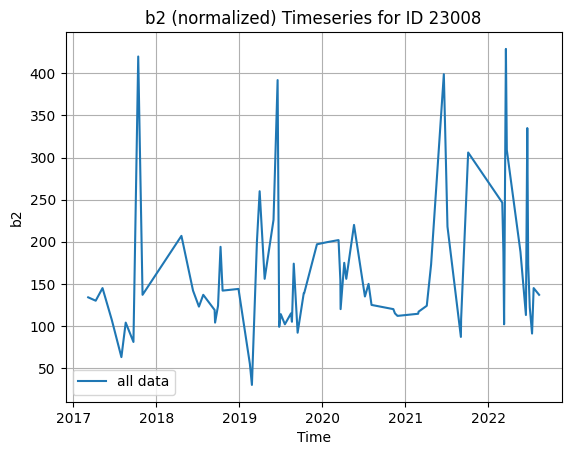

In [172]:
plot_timeseries_oneid(
    df, 23008, "b2", yearly_mean=False
)